#  Мониторинг процесса обучения

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
* https://docs.wandb.ai/quickstart
* https://docs.wandb.ai/guides/track/log/log-summary#docusaurus_skipToContent_fallback
* https://docs.wandb.ai/guides/track/log/log-models
* https://www.youtube.com/playlist?list=PLD80i8An1OEGajeVo15ohAQYF1Ttle0lk

## Задачи для совместного разбора

In [34]:
# !pip install wandb

In [1]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alnator (alnator-financial-university). Use `wandb login --relogin` to force relogin


True

1\. Рассмотрите возможности пакета `wandb` по отслеживанию числовых значений, визуализации изображений и таблиц.

In [36]:
import torch as th
def train(num_epochs: int):
  for x in range(num_epochs):
    x = th.tensor(x)
    loss = th.exp(-x/num_epochs)
    r2 = th.randn(size=(1,))
    wandb.log({"train/loss": loss, "train/r2": r2})
  wandb.run.summary["test/r2"] = 1

In [37]:
with wandb.init(
    project="seminar-tutorial",
    # name="run2",
    tags=["demo"],
    config={"num_epochs": 100}
):
  train(100)

train/loss,██▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train/r2,▄▄▆█▆▆▄▇▅▃▅█▅▁▄▁▄▅▆█▅▅▄▅▆▇▇▃▅▆▇▆▆▇▅▃▅▆▇▇
test/r2,1
train/loss,0.37158
train/r2,1.08445


In [38]:
import seaborn as sns

sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

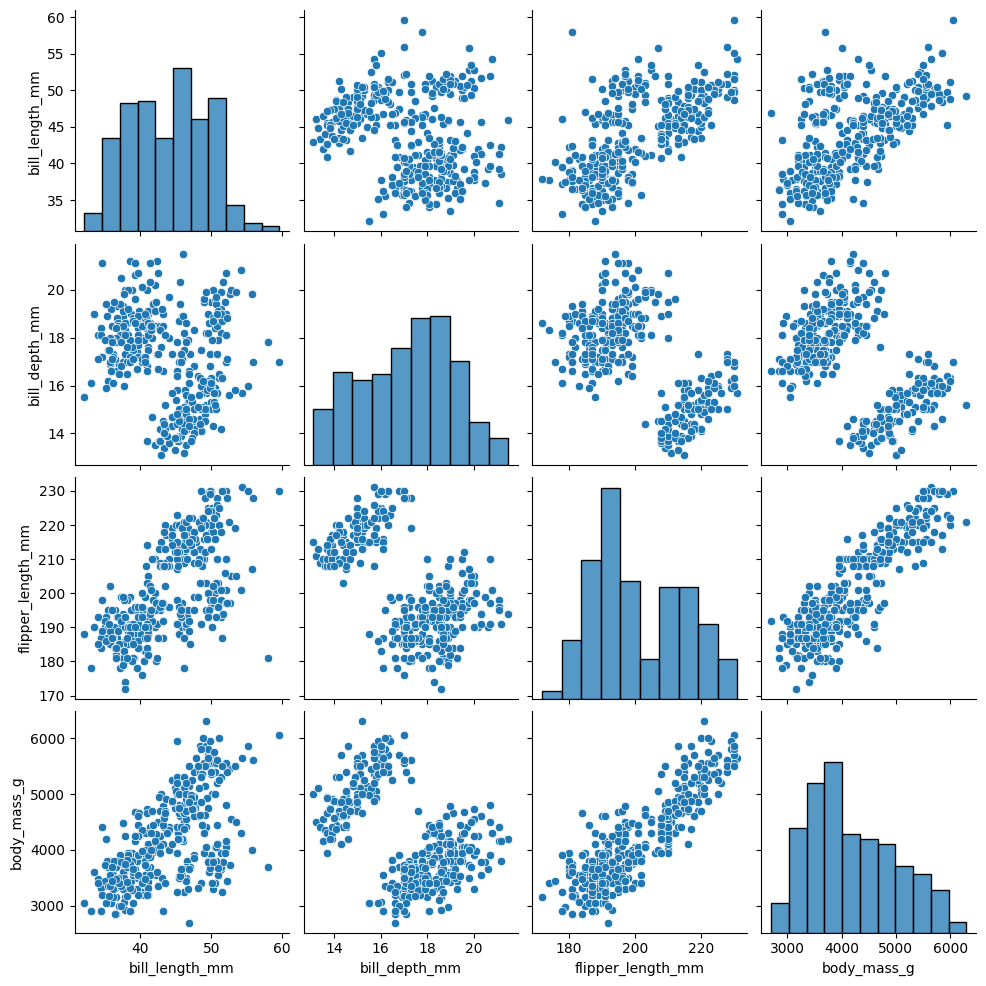

In [39]:
with wandb.init(
    project="seminar-tutorial",
    # name="run2",
    tags=["demo"],
    config={"num_epochs": 100}
):
  dataset = sns.load_dataset("penguins")
  img = sns.pairplot(dataset)
  wandb.log({"train/pairplot": wandb.Image(img.figure)})

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Решите задачу регрессии, используя для мониторинга процесса обучения `wandb`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики $R^2$ по эпохам. После завершения обучения рассчитайте значение метрик MSE, RMSE, MAE и MAPE и сохраните в виде summary данного запуска.

Обучите не менее трех моделей (с разной архитектурой или гиперпараметрами), отследите все запуски при помощи `wandb` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели и summary (страница overview).

- [ ] Проверено на семинаре

In [14]:
import torch as th
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics as M
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

wandb.login()

True

In [3]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

Используемое устройство: cuda


In [5]:
X = th.linspace(0, 1, 100).view(-1, 1).to(device)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size()).to(device)

dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
def train_model_with_metrics(model, criterion, optimizer, train_loader, n_epochs=1000, print_every=100):
    epoch_losses = []
    r2_scores = []

    loss_metric = M.MeanMetric().to(device)
    r2_metric = M.R2Score().to(device)
    for epoch in range(n_epochs+1):
        loss_metric.reset()  
        r2_metric.reset()
        
        for X_batch, y_batch in train_loader:
            model.train()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_metric.update(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_metric.compute().item()
        epoch_losses.append(epoch_loss)

        model.eval()
        with th.no_grad():
            for X_batch, y_batch in train_loader:
                y_pred_test = model(X_batch)
                r2_metric.update(y_pred_test, y_batch)
            r2_score = r2_metric.compute().item()
            r2_scores.append(r2_score)

        wandb.log({"epoch": epoch, "train loss": epoch_loss, "train R2": r2_score})
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}, R²: {r2_score:.4f}')

    return epoch_losses, r2_scores

def model_eval(model, test_loader):
    model.eval()
    y_pred_list, y_test_list = [], []
    with th.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred)
            y_test_list.append(y_batch)

    y_pred_test = th.cat(y_pred_list)
    y_test = th.cat(y_test_list)

    mae = M.MeanAbsoluteError().to(device)(y_pred_test, y_test).item()
    mape = M.MeanAbsolutePercentageError().to(device)(y_pred_test, y_test).item()
    mse = M.MeanSquaredError().to(device)(y_pred_test, y_test).item()
    rmse = mse ** 0.5
    r2 = M.R2Score().to(device)(y_pred_test, y_test).item()

    wandb.summary["MSE"] = mse
    wandb.summary["RMSE"] = rmse
    wandb.summary["MAE"] = mae
    wandb.summary["MAPE"] = mape
    wandb.summary["R2"] = r2

In [7]:
class SineActivation(nn.Module):
    def forward(self, x):
        return th.sin(x)

models = {
    "Model_1": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Tanh(),
        nn.Linear(16, 1),
    ).to(device),
    
    "Model_2": nn.Sequential(
        nn.Linear(X.shape[1], 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
    ).to(device),

    "Model_3": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        SineActivation(),
        nn.Linear(16, 16),
        nn.Tanh(),
        nn.Linear(16, 1),
    ).to(device),
}

In [9]:
for model_name, model in models.items():
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    with wandb.init(
        project="03_1_monitoring",
        group="task_1",
        name=model_name,
        config={
            "learning_rate": 0.005,
            "batch_size": 16,
            "epochs": 1000,
            "model": model_name
        }
    ):

        epoch_losses, r2_scores = train_model_with_metrics(
            model, 
            criterion, 
            optimizer, 
            train_loader,
            n_epochs=1000
        )
        model_eval(model, test_loader)

Epoch [0/1000], Loss: 0.5479, R²: 0.0136
Epoch [100/1000], Loss: 0.1818, R²: 0.6454
Epoch [200/1000], Loss: 0.1490, R²: 0.7117
Epoch [300/1000], Loss: 0.0650, R²: 0.8755
Epoch [400/1000], Loss: 0.0284, R²: 0.9453
Epoch [500/1000], Loss: 0.0145, R²: 0.9718
Epoch [600/1000], Loss: 0.0087, R²: 0.9836
Epoch [700/1000], Loss: 0.0041, R²: 0.9921
Epoch [800/1000], Loss: 0.0024, R²: 0.9953
Epoch [900/1000], Loss: 0.0017, R²: 0.9969
Epoch [1000/1000], Loss: 0.0017, R²: 0.9957


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇████
train R2,▁▁▁▁▁▄▄▄▅▆▇▇▇▇▇▇▇███████████████████████
train loss,█▆▆▆▆▅▅▅▅▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,0.03329
MAPE,0.2799
MSE,0.00193
R2,0.99537
RMSE,0.0439
epoch,1000
train R2,0.9957
train loss,0.00173


Epoch [0/1000], Loss: 0.5046, R²: 0.1369
Epoch [100/1000], Loss: 0.0639, R²: 0.9284
Epoch [200/1000], Loss: 0.0351, R²: 0.9499
Epoch [300/1000], Loss: 0.0301, R²: 0.9695
Epoch [400/1000], Loss: 0.0275, R²: 0.9645
Epoch [500/1000], Loss: 0.0268, R²: 0.9732
Epoch [600/1000], Loss: 0.0187, R²: 0.9622
Epoch [700/1000], Loss: 0.0226, R²: 0.9484
Epoch [800/1000], Loss: 0.0164, R²: 0.9419
Epoch [900/1000], Loss: 0.0147, R²: 0.9281
Epoch [1000/1000], Loss: 0.0090, R²: 0.9067


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██
train R2,▁▂▄▆▆▇▇▇▇▇▇▇█▇█▇█▇▇█▇▇▆▇█▇▆▇█▇▅▇▆▄▆▅▅▅▅▂
train loss,█▆▄▄▃▃▄▂▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
MAE,0.14663
MAPE,1.36796
MSE,0.05659
R2,0.86396
RMSE,0.23788
epoch,1000
train R2,0.90668
train loss,0.00897


Epoch [0/1000], Loss: 0.4782, R²: 0.1953
Epoch [100/1000], Loss: 0.0131, R²: 0.9764
Epoch [200/1000], Loss: 0.0011, R²: 0.9981
Epoch [300/1000], Loss: 0.0011, R²: 0.9982
Epoch [400/1000], Loss: 0.0010, R²: 0.9980
Epoch [500/1000], Loss: 0.0011, R²: 0.9976
Epoch [600/1000], Loss: 0.0009, R²: 0.9981
Epoch [700/1000], Loss: 0.0010, R²: 0.9981
Epoch [800/1000], Loss: 0.0012, R²: 0.9983
Epoch [900/1000], Loss: 0.0009, R²: 0.9985
Epoch [1000/1000], Loss: 0.0009, R²: 0.9984


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train R2,▁▂▆█████████████████████████████████████
train loss,██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE,0.02648
MAPE,0.06871
MSE,0.0009
R2,0.99784
RMSE,0.02994
epoch,1000
train R2,0.99841
train loss,0.00093


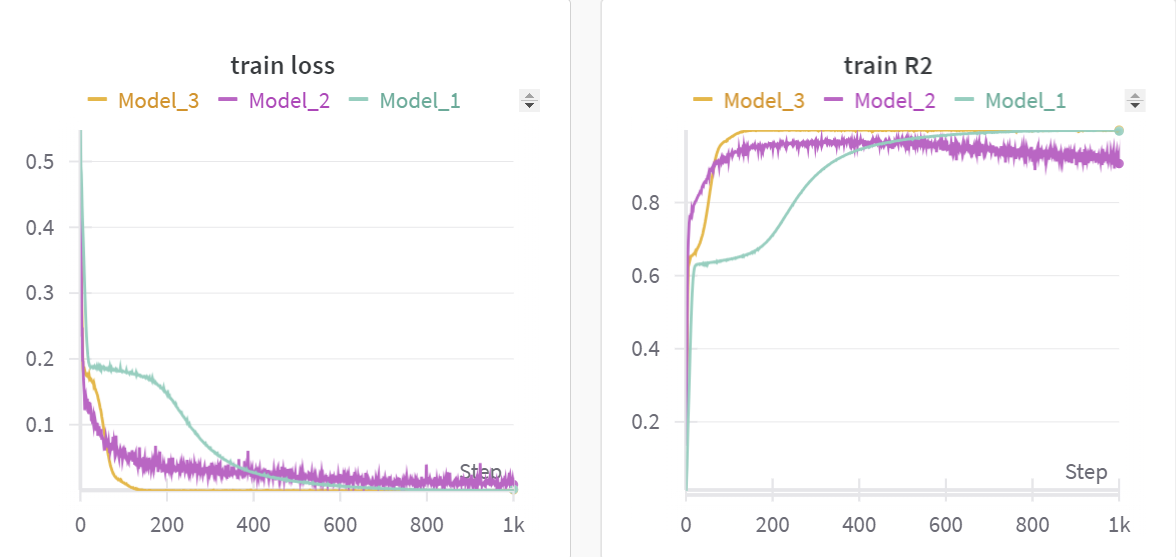

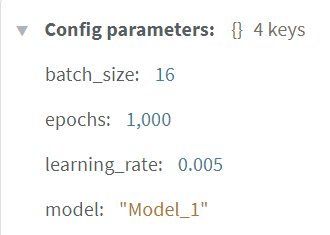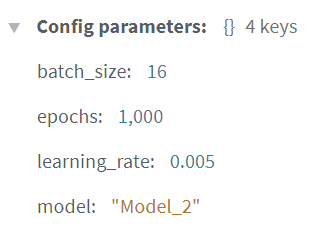 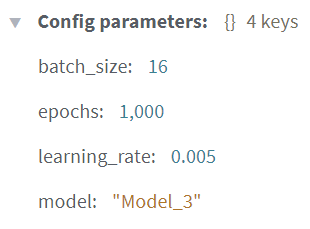 \
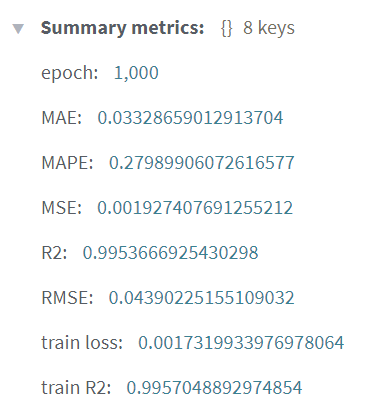 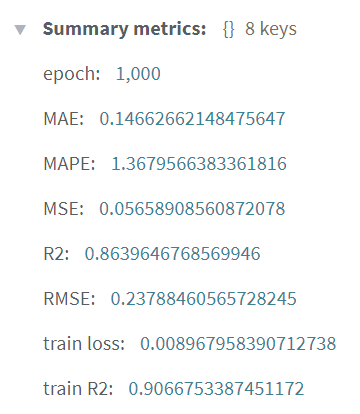 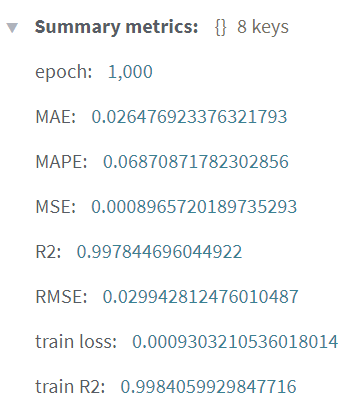

<p class="task" id="2"></p>

2\. Решите задачу классификации, используя для мониторинга процесса обучения `wandb`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики `Accuracy` по эпохам. После завершения обучения рассчитайте значение метрик Accuracy, Precision, Recall и F1 и сохраните в виде summary данного запуска.

Отследите все запуски при помощи `wandb` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели и summary (страница overview).


- [ ] Проверено на семинаре

In [ ]:
def train_model_with_metrics(model, criterion, optimizer, train_loader, n_epochs=1000, print_every=100):
    epoch_losses = []
    accuracy_scores = []

    loss_metric = M.MeanMetric().to(device)
    accuracy_metric = M.Accuracy('binary').to(device)
    for epoch in range(n_epochs+1):
        loss_metric.reset()  
        accuracy_metric.reset()
        
        for X_batch, y_batch in train_loader:
            model.train()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_metric.update(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_metric.compute().item()
        epoch_losses.append(epoch_loss)

        model.eval()
        with th.no_grad():
            for X_batch, y_batch in train_loader:
                y_pred_test = model(X_batch)
                accuracy_metric.update(y_pred_test.argmax(dim=1), y_batch)
            accuracy = accuracy_metric.compute().item()
            accuracy_scores.append(accuracy)

        wandb.log({"epoch": epoch, "train loss": epoch_loss, "train accuracy": accuracy})
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}, accuracy: {accuracy:.4f}')

    return epoch_losses, accuracy

def model_eval(model, test_loader):
    model.eval()
    y_pred_list, y_test_list = [], []
    with th.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred)
            y_test_list.append(y_batch)

    y_pred_test = th.cat(y_pred_list).argmax(dim=1)
    y_test = th.cat(y_test_list)

    accuracy = M.Accuracy('binary').to(device)(y_pred_test, y_test).item()
    precision = M.Precision('binary').to(device)(y_pred_test, y_test).item()
    recall = M.Recall('binary').to(device)(y_pred_test, y_test).item()
    f1_score = M.F1Score('binary').to(device)(y_pred_test, y_test).item()

    wandb.summary["Accuracy"] = accuracy
    wandb.summary["Precision"] = precision
    wandb.summary["Recall"] = recall
    wandb.summary["F1Score"] = f1_score

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X).to(device)
y = th.LongTensor(y).to(device)

dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
models = {
    "Model_1": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Tanh(),
        nn.Linear(16, 2),
    ).to(device),
    
    "Model_2": nn.Sequential(
        nn.Linear(X.shape[1], 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
    ).to(device),

    "Model_3": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Tanh(),
        nn.Linear(16, 16),
        nn.Tanh(),
        nn.Linear(16, 2),
    ).to(device),
}

In [ ]:
for model_name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.005)
    
    with wandb.init(
        project="03_1_monitoring",
        group="task_2",
        name=model_name,
        config={
            "learning_rate": 0.005,
            "batch_size": 16,
            "epochs": 500,
            "model": model_name
        }
    ):

        epoch_losses, accuracy = train_model_with_metrics(
            model, 
            criterion, 
            optimizer, 
            train_loader,
            n_epochs=500
        )
        model_eval(model, test_loader)

Epoch [0/500], Loss: 0.6985, accuracy: 0.5350
Epoch [100/500], Loss: 0.1616, accuracy: 0.9737
Epoch [200/500], Loss: 0.1101, accuracy: 0.9675
Epoch [300/500], Loss: 0.1019, accuracy: 0.9787
Epoch [400/500], Loss: 0.0992, accuracy: 0.9775
Epoch [500/500], Loss: 0.1009, accuracy: 0.9762


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
train accuracy,▁▇██████████████████████████████████████
train loss,██▇▇▇▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.955
F1Score,0.94972
Precision,0.96591
Recall,0.93407
epoch,500
train accuracy,0.97625
train loss,0.10092


Epoch [0/500], Loss: 0.6903, accuracy: 0.7912
Epoch [100/500], Loss: 0.1548, accuracy: 0.9737
Epoch [200/500], Loss: 0.1683, accuracy: 0.9775
Epoch [300/500], Loss: 0.1359, accuracy: 0.9700
Epoch [400/500], Loss: 0.1549, accuracy: 0.9737
Epoch [500/500], Loss: 0.1475, accuracy: 0.9663


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train accuracy,▂▂▃▅▅▄▄▄▆▆▁▆▆▇▆▂▇▅▃▄▇▃▅▆▃▅▃██▆▇▃▆▄▅▅▆▅▁▆
train loss,█▃▃▃▃▃▂▄▂▂▂▂▁▂▂▁▂▂▂▂▁▁▂▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▂▁
Accuracy,0.95
F1Score,0.94253
Precision,0.98795
Recall,0.9011
epoch,500
train accuracy,0.96625
train loss,0.14745


Epoch [0/500], Loss: 0.6970, accuracy: 0.5113
Epoch [100/500], Loss: 0.0768, accuracy: 0.9575
Epoch [200/500], Loss: 0.0848, accuracy: 0.9725
Epoch [300/500], Loss: 0.0870, accuracy: 0.9712
Epoch [400/500], Loss: 0.0970, accuracy: 0.9137
Epoch [500/500], Loss: 0.1198, accuracy: 0.9675


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
train accuracy,▅▆▇▂▆▇▇▇▆▅█▇▆▅▇▅▇▇▄▇▇▆▇▆▇█▆▇▆▅▇▆▅▆▆▇▅█▂▁
train loss,█▂▂▂▂▁▄▁▂▁▁▂▂▁▁▂▁▁▂▁▂▂▁▂▂▁▂▃▁▁▁▁▂▁▁▂▂▂▂▁
Accuracy,0.97
F1Score,0.96739
Precision,0.95699
Recall,0.97802
epoch,500
train accuracy,0.9675
train loss,0.11984


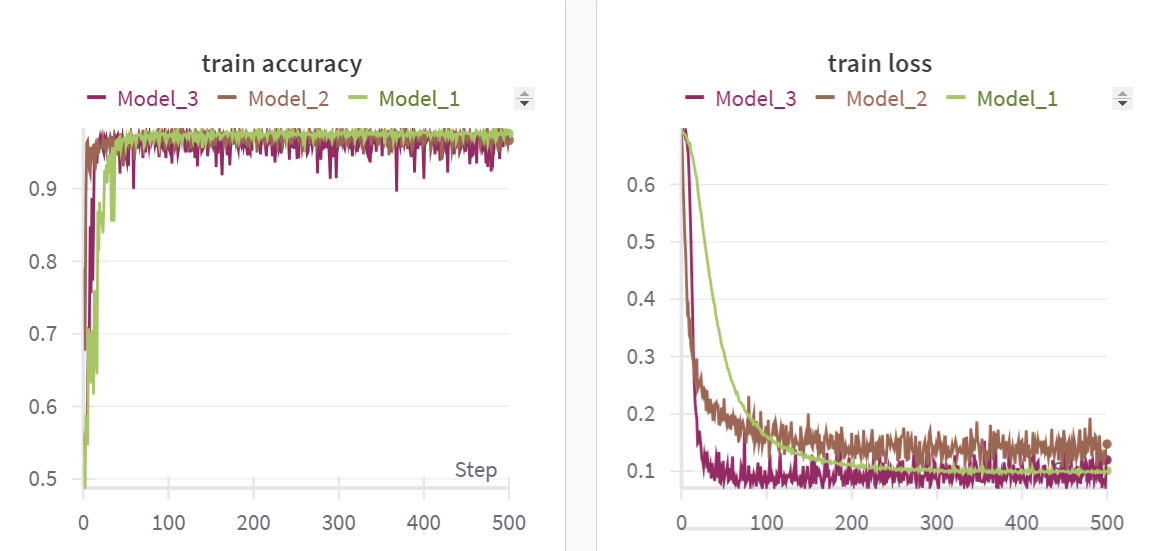

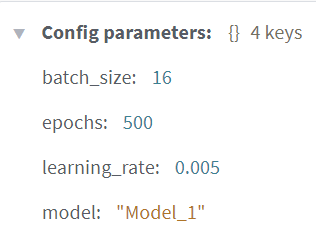 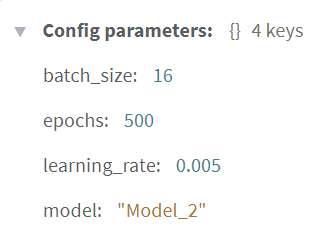 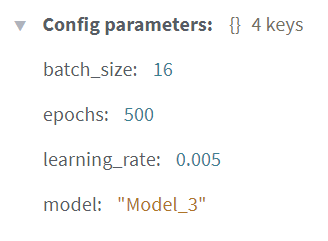

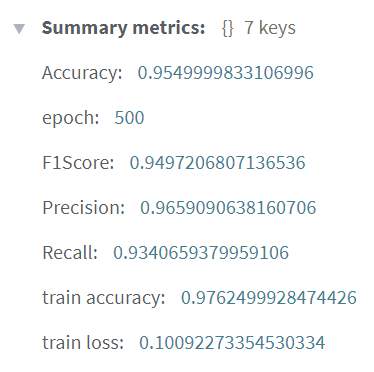 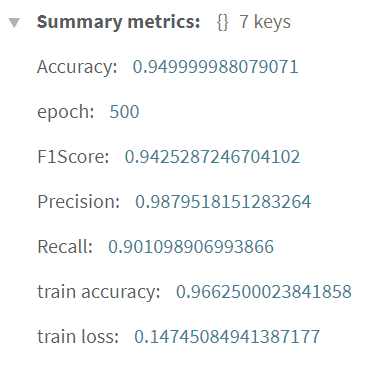 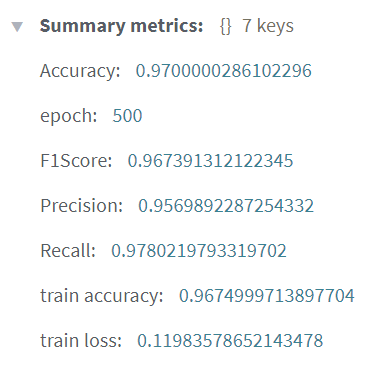

<p class="task" id="3"></p>

3\. Повторите задачу 2, вычислив и визуализировав матрицу несоответствий (для обучающей и тестовой выборки) тремя способами при помощи `wandb`:
* используя `torchmetrics` и представив данные в виде объекта `wandb.Table`;
* используя готовую функцию `wandb.plot.confusion_matrix`;
* построив тепловую карту при помощи `seaborn` и представив данные в виде объекта `wandb.Image`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

In [7]:
def compute_and_log_confusion_matrix(y_pred, y_true, name_prefix="train"):
    conf_matrix = M.ConfusionMatrix(task="binary", num_classes=2).to(device)(y_pred, y_true).cpu().numpy()
    table_data = [[int(conf_matrix[i, j]) for j in range(conf_matrix.shape[1])] for i in range(conf_matrix.shape[0])]
    columns = [f"Pred_{i}" for i in range(conf_matrix.shape[1])]
    table = wandb.Table(data=table_data, columns=columns)
    wandb.log({f"{name_prefix}_confusion_matrix_table": table})

    wandb.log({f"{name_prefix}_confusion_matrix": wandb.plot.confusion_matrix(
        preds=y_pred.cpu().numpy(),
        y_true=y_true.cpu().numpy(),
        class_names=[str(i) for i in range(2)]
    )})

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=columns, yticklabels=columns)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{name_prefix.capitalize()} Confusion Matrix")
    wandb.log({f"{name_prefix}_confusion_matrix_heatmap": wandb.Image(plt)})
    plt.close()

def train_model_with_metrics(model, criterion, optimizer, train_loader, n_epochs=1000, print_every=100):
    epoch_losses = []
    accuracy_scores = []

    loss_metric = M.MeanMetric().to(device)
    accuracy_metric = M.Accuracy('binary').to(device)
    for epoch in range(n_epochs+1):
        loss_metric.reset()  
        accuracy_metric.reset()
        
        for X_batch, y_batch in train_loader:
            model.train()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_metric.update(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_metric.compute().item()
        epoch_losses.append(epoch_loss)

        model.eval()
        with th.no_grad():
            y_pred_train, y_train = [], []
            for X_batch, y_batch in train_loader:
                y_pred_batch = model(X_batch)
                y_pred_train.append(y_pred_batch)
                y_train.append(y_batch)
                accuracy_metric.update(y_pred_batch.argmax(dim=1), y_batch)

            y_pred_train = th.cat(y_pred_train).argmax(dim=1)
            y_train = th.cat(y_train)
            accuracy = accuracy_metric.compute().item()
            accuracy_scores.append(accuracy)

            compute_and_log_confusion_matrix(y_pred_train, y_train, name_prefix="train")

        wandb.log({"epoch": epoch, "train loss": epoch_loss, "train accuracy": accuracy})
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}, accuracy: {accuracy:.4f}')

    return epoch_losses, accuracy

def model_eval(model, test_loader):
    model.eval()
    y_pred_list, y_test_list = [], []
    with th.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred)
            y_test_list.append(y_batch)

    y_pred_test = th.cat(y_pred_list).argmax(dim=1)
    y_test = th.cat(y_test_list)

    compute_and_log_confusion_matrix(y_pred_test, y_test, name_prefix="test")

    accuracy = M.Accuracy('binary').to(device)(y_pred_test, y_test).item()
    precision = M.Precision('binary').to(device)(y_pred_test, y_test).item()
    recall = M.Recall('binary').to(device)(y_pred_test, y_test).item()
    f1_score = M.F1Score('binary').to(device)(y_pred_test, y_test).item()

    wandb.summary["Accuracy"] = accuracy
    wandb.summary["Precision"] = precision
    wandb.summary["Recall"] = recall
    wandb.summary["F1Score"] = f1_score

In [8]:
for model_name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.005)
    
    with wandb.init(
        project="03_1_monitoring",
        group="task_3",
        name=model_name,
        config={
            "learning_rate": 0.005,
            "batch_size": 16,
            "epochs": 50,
            "model": model_name
        }
    ):

        epoch_losses, accuracy = train_model_with_metrics(
            model, 
            criterion, 
            optimizer, 
            train_loader,
            n_epochs=50,
            print_every=10
        )
        model_eval(model, test_loader)

Epoch [0/50], Loss: 0.6941, accuracy: 0.5350
Epoch [10/50], Loss: 0.6650, accuracy: 0.5788
Epoch [20/50], Loss: 0.5795, accuracy: 0.7950
Epoch [30/50], Loss: 0.4696, accuracy: 0.9550
Epoch [40/50], Loss: 0.3865, accuracy: 0.9588
Epoch [50/50], Loss: 0.3102, accuracy: 0.9600


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train accuracy,▂▁▁▂▃▄▃▂▄▂▅▅▆▅▇▆▆▅▆▇▆▇██▇███▇███████████
train loss,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
Accuracy,0.955
F1Score,0.95652
Precision,0.9802
Recall,0.93396
epoch,50
train accuracy,0.96
train loss,0.31025


Epoch [0/50], Loss: 0.6896, accuracy: 0.6700
Epoch [10/50], Loss: 0.2776, accuracy: 0.9588
Epoch [20/50], Loss: 0.2005, accuracy: 0.9638
Epoch [30/50], Loss: 0.1523, accuracy: 0.9650
Epoch [40/50], Loss: 0.1580, accuracy: 0.9700
Epoch [50/50], Loss: 0.1657, accuracy: 0.9737


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train accuracy,▁▄▃▆▆▇███▇████████▇████▇███████▇████████
train loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.955
F1Score,0.95694
Precision,0.97087
Recall,0.9434
epoch,50
train accuracy,0.97375
train loss,0.16573


Epoch [0/50], Loss: 0.7043, accuracy: 0.5075
Epoch [10/50], Loss: 0.6653, accuracy: 0.6137
Epoch [20/50], Loss: 0.2067, accuracy: 0.9100
Epoch [30/50], Loss: 0.1178, accuracy: 0.9287
Epoch [40/50], Loss: 0.1088, accuracy: 0.9650
Epoch [50/50], Loss: 0.1338, accuracy: 0.9737


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train accuracy,▁▂▁▁▁▂▂▁▃▃▅▅▇▅█▇▇▇█▇█████▇████▇█████████
train loss,██████████▇▇▆▅▅▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
Accuracy,0.97
F1Score,0.97143
Precision,0.98077
Recall,0.96226
epoch,50
train accuracy,0.97375
train loss,0.13379


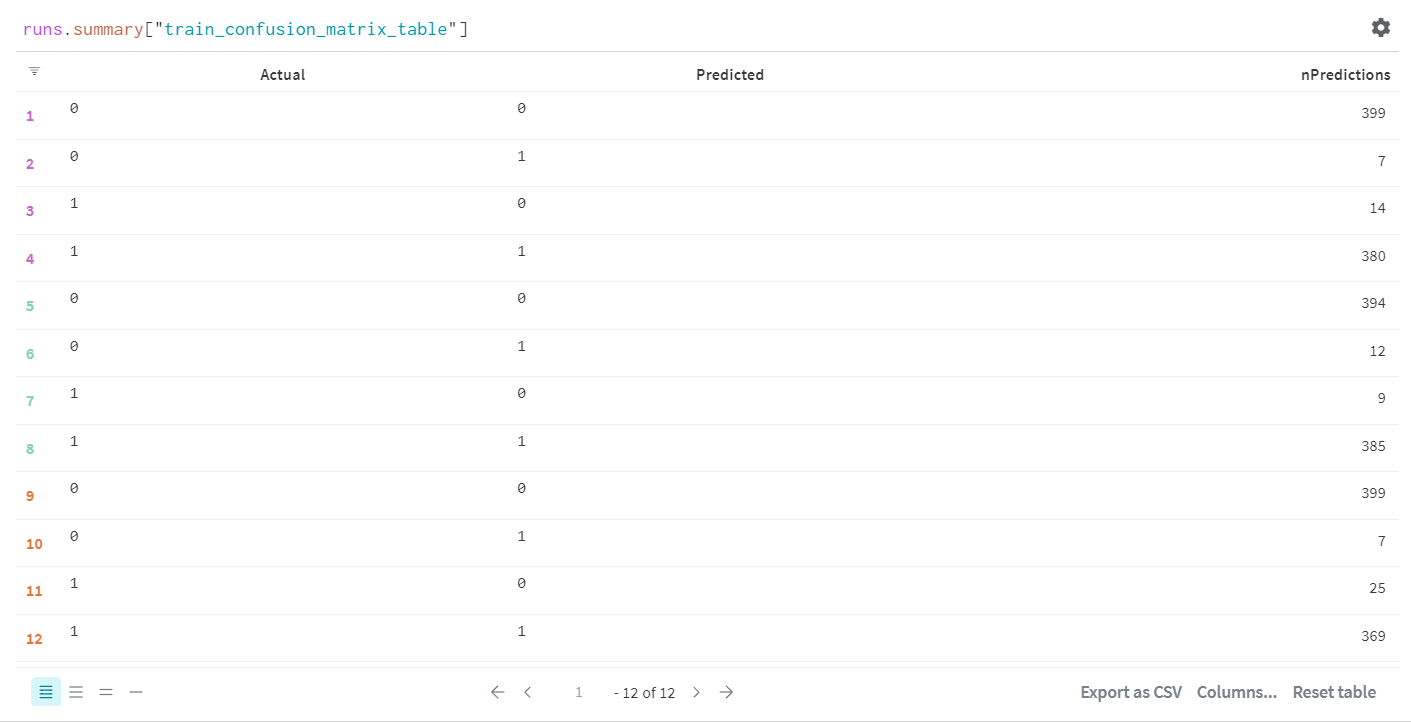\
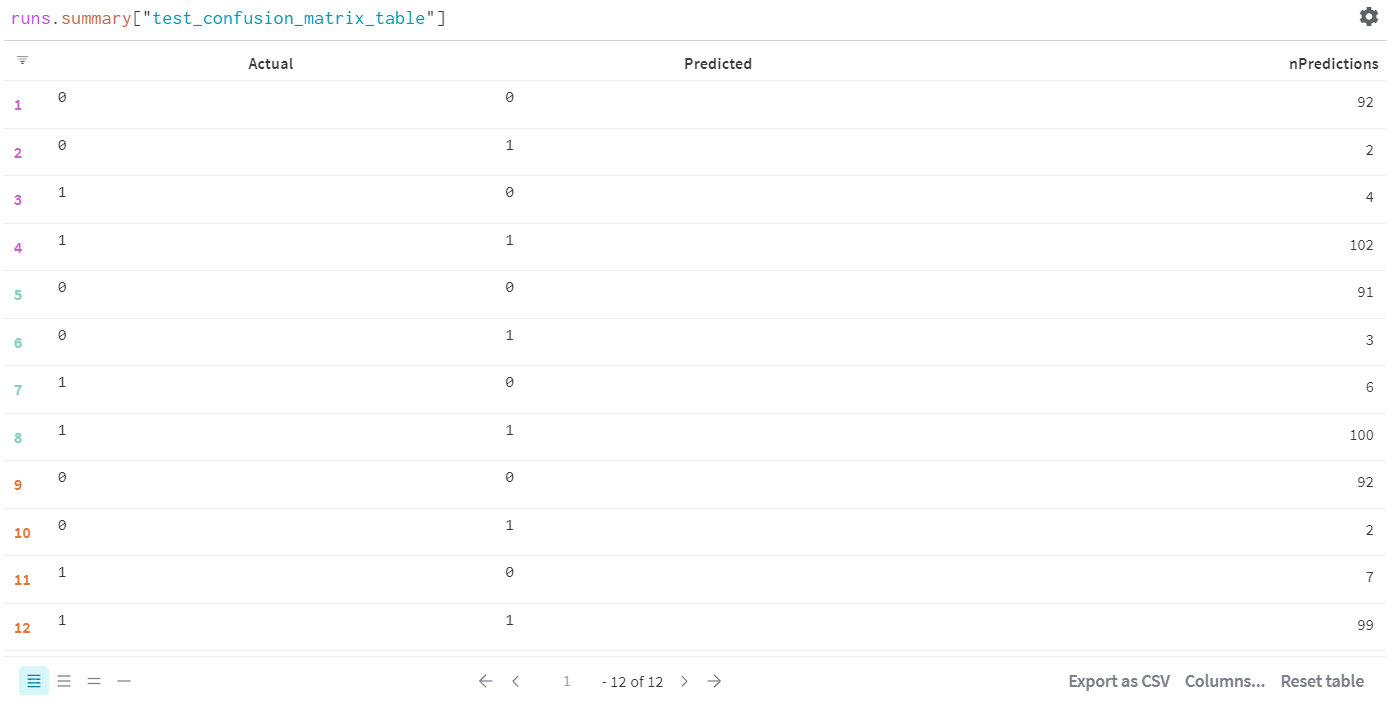\
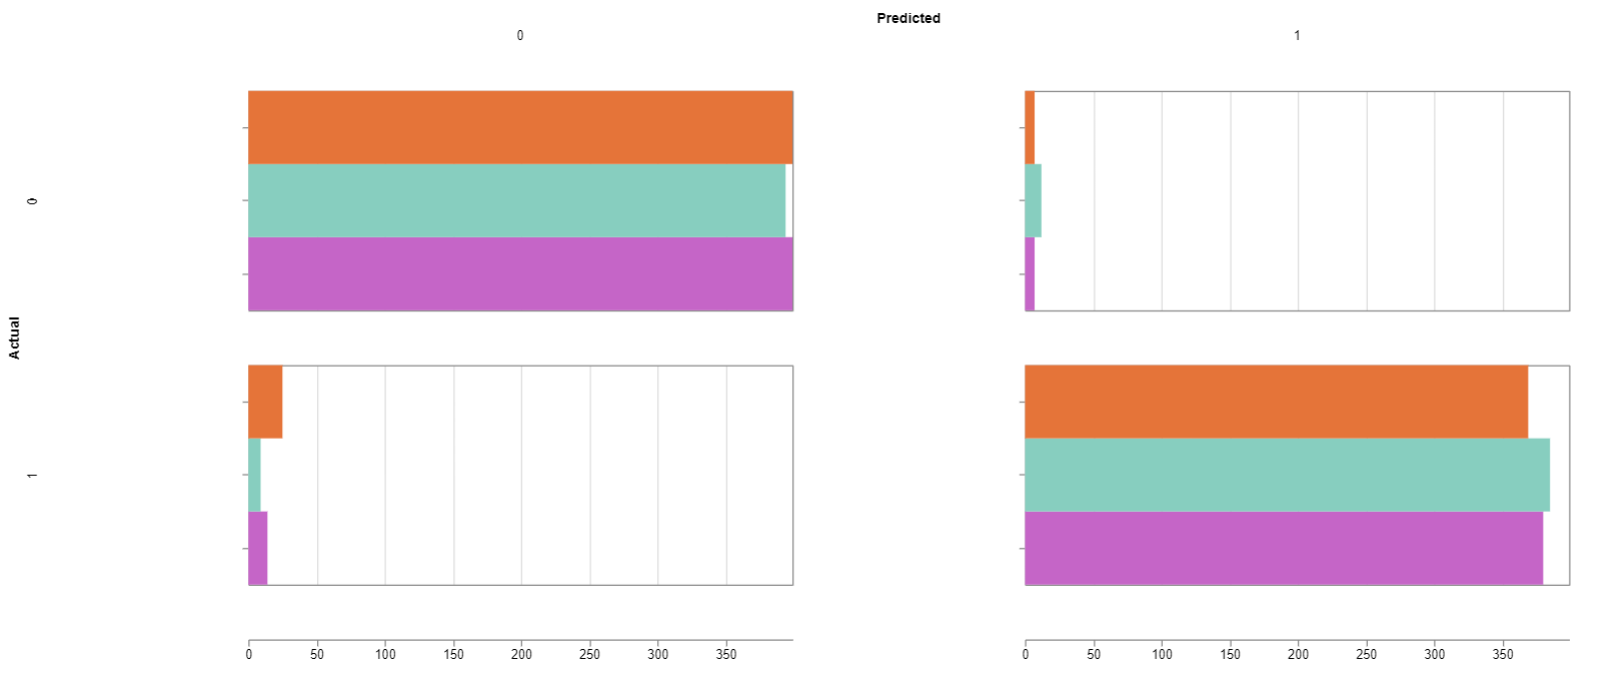 \
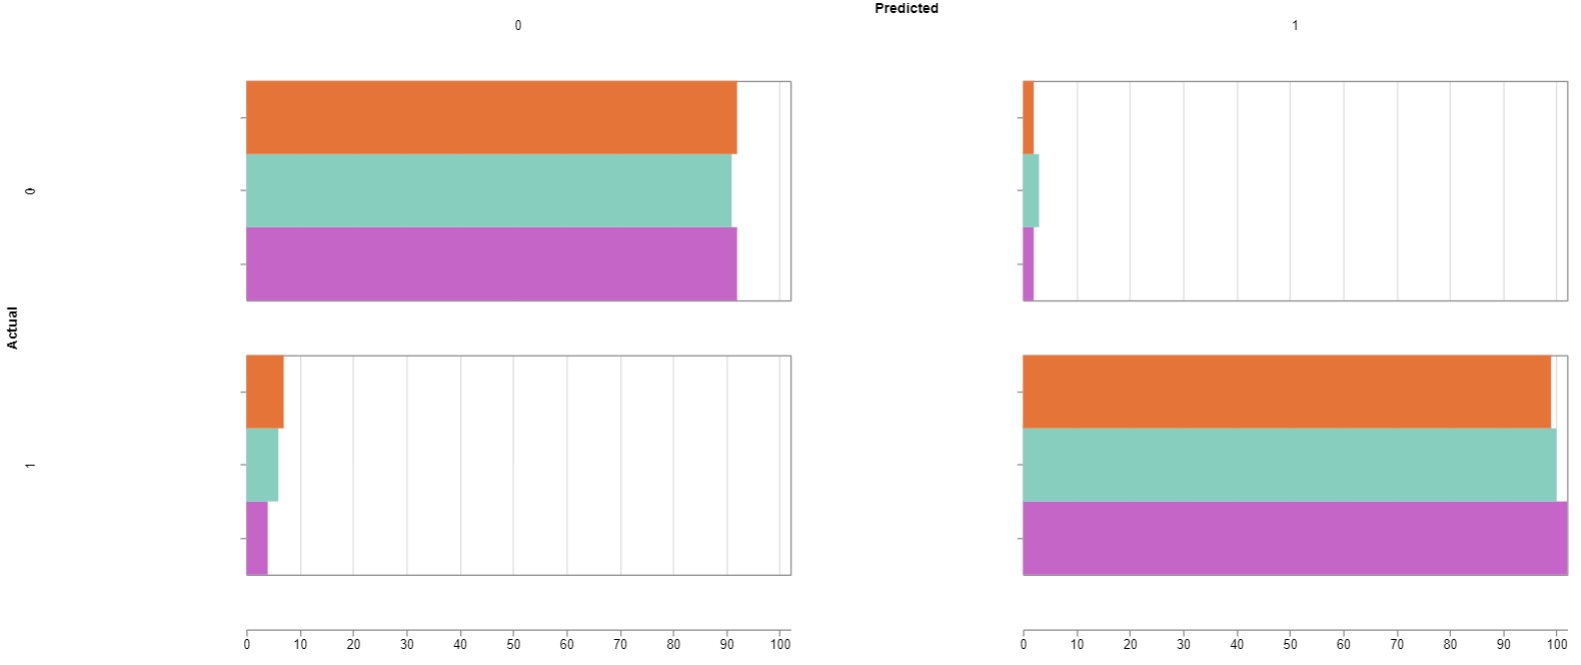 \
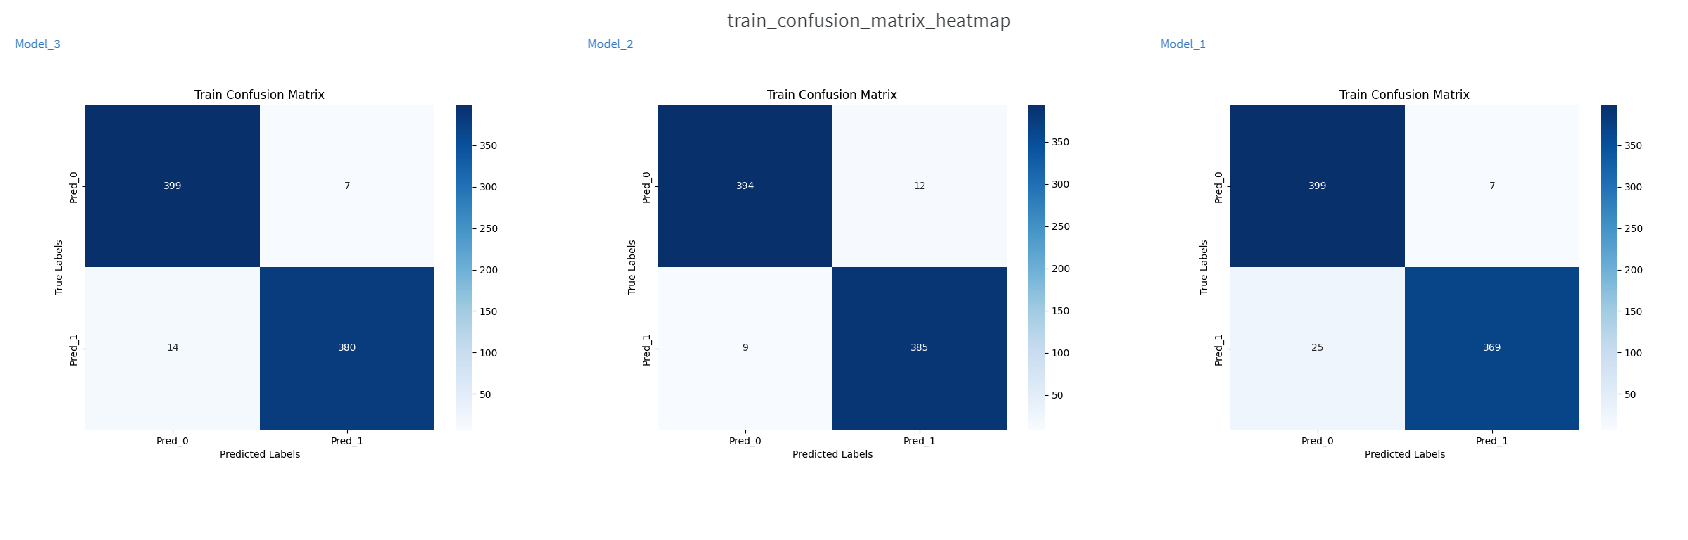 \
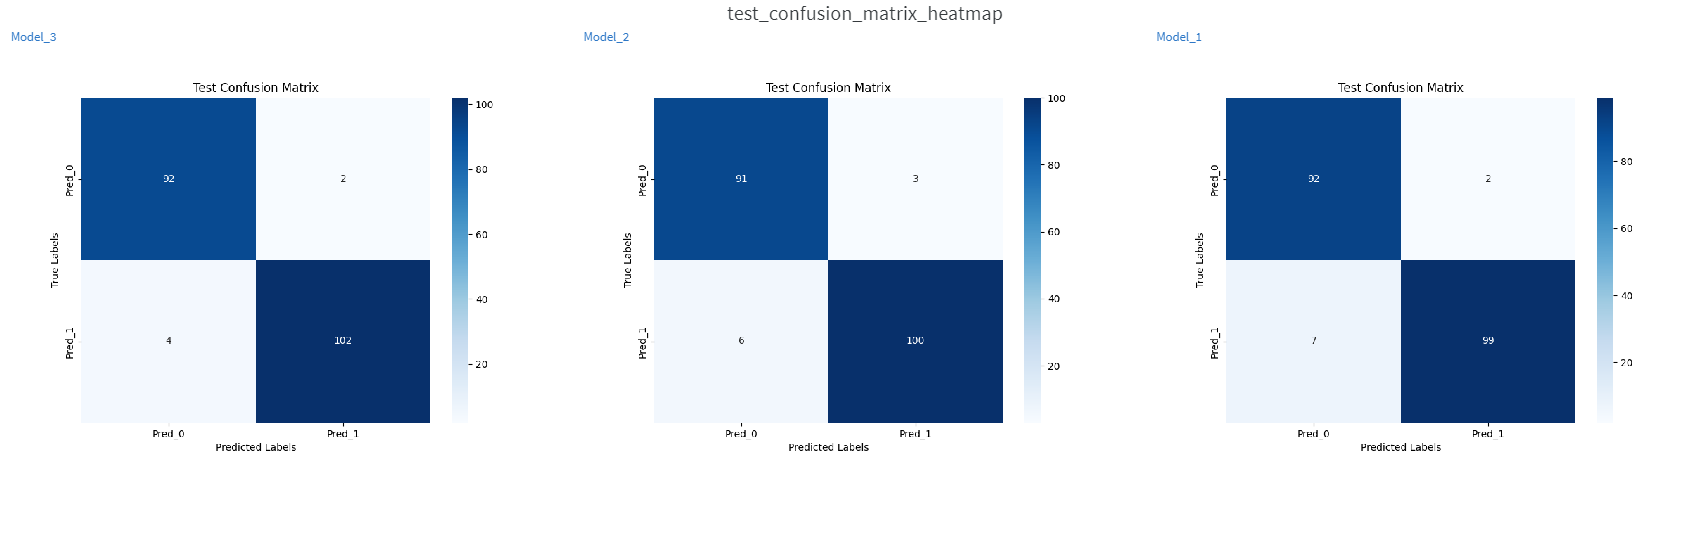

<p class="task" id="4"></p>

4\. Повторите задачу 2, обучив две модели: линейную и нелинейную. Для каждой из моделей сделайте прогноз (по всей выборке) и визуализируйте облако точек в виде `wandb.Image` (раскрасьте точки в цвета, соответствующие прогнозам модели).

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

In [4]:
def train_model_with_metrics(model, criterion, optimizer, train_loader, n_epochs=1000, print_every=100):
    epoch_losses = []
    accuracy_scores = []

    loss_metric = M.MeanMetric().to(device)
    accuracy_metric = M.Accuracy('binary').to(device)
    for epoch in range(n_epochs+1):
        loss_metric.reset()  
        accuracy_metric.reset()
        
        for X_batch, y_batch in train_loader:
            model.train()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_metric.update(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_metric.compute().item()
        epoch_losses.append(epoch_loss)

        model.eval()
        with th.no_grad():
            for X_batch, y_batch in train_loader:
                y_pred_test = model(X_batch)
                accuracy_metric.update(y_pred_test.argmax(dim=1), y_batch)
            accuracy = accuracy_metric.compute().item()
            accuracy_scores.append(accuracy)

        wandb.log({"epoch": epoch, "train loss": epoch_loss, "train accuracy": accuracy})
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}, accuracy: {accuracy:.4f}')

    return epoch_losses, accuracy

def model_eval(model, test_loader):
    model.eval()
    y_pred_list, y_test_list = [], []
    with th.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred)
            y_test_list.append(y_batch)

    y_pred_test = th.cat(y_pred_list).argmax(dim=1)
    y_test = th.cat(y_test_list)

    accuracy = M.Accuracy('binary').to(device)(y_pred_test, y_test).item()
    precision = M.Precision('binary').to(device)(y_pred_test, y_test).item()
    recall = M.Recall('binary').to(device)(y_pred_test, y_test).item()
    f1_score = M.F1Score('binary').to(device)(y_pred_test, y_test).item()

    wandb.summary["Accuracy"] = accuracy
    wandb.summary["Precision"] = precision
    wandb.summary["Recall"] = recall
    wandb.summary["F1Score"] = f1_score
    
def visualize_predictions(model, X, y, model_name, labels):
    model.eval()
    with th.no_grad():
        X = X.to(device)
        y_pred = model(X).argmax(dim=1).cpu().numpy()
    y = y.cpu().numpy()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y_pred, cmap='viridis', alpha=0.7)
    plt.title(f'Предсказания модели: {model_name}')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=labels)
    plt.grid(True)

    image = wandb.Image(plt, caption=f'Предсказания модели: {model_name}')
    wandb.log({f"{model_name} Predictions": image})
    plt.close()

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X).to(device)
y = th.LongTensor(y).to(device)

dataset = TensorDataset(X, y)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
models = {
    "Linear_Model": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Linear(16, 2),
    ).to(device),
    
    "Nonlinear_Model": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Tanh(),
        nn.Linear(16, 2),
    ).to(device),
}

In [7]:
labels = ["Класс 0", "Класс 1"]

for model_name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.005)
    
    with wandb.init(
        project="03_1_monitoring",
        group="task_4",
        name=model_name,
        config={
            "learning_rate": 0.005,
            "batch_size": 16,
            "epochs": 500,
            "model": model_name
        }
    ):

        epoch_losses, accuracy = train_model_with_metrics(
            model, 
            criterion, 
            optimizer, 
            train_loader,
            n_epochs=500
        )
        model_eval(model, test_loader)
        visualize_predictions(model, X, y, model_name, labels)

Epoch [0/500], Loss: 0.7027, accuracy: 0.5013
Epoch [100/500], Loss: 0.6944, accuracy: 0.5088
Epoch [200/500], Loss: 0.6933, accuracy: 0.5163
Epoch [300/500], Loss: 0.6940, accuracy: 0.5013
Epoch [400/500], Loss: 0.6934, accuracy: 0.5462
Epoch [500/500], Loss: 0.6934, accuracy: 0.5325


epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train accuracy,▇▅▃▁▇▅▅▅▅▃▅▅▆▅█▆▅▅▄▅▃▅▅▅▅▆▅▅▅▅▇▆▅▅▅▅▅▅▅▅
train loss,▄█▃▆▂▂▂▁▃▂▁▁▁▁▅▂▃▁▁▂▅▂▂▁▁▂▃▄▁▂▂▄▆▃▂▂▃▂▁▁
Accuracy,0.53
F1Score,0.60169
Precision,0.51825
Recall,0.71717
epoch,500
train accuracy,0.5325
train loss,0.69345


Epoch [0/500], Loss: 0.7058, accuracy: 0.5138
Epoch [100/500], Loss: 0.1651, accuracy: 0.9775
Epoch [200/500], Loss: 0.1160, accuracy: 0.9775
Epoch [300/500], Loss: 0.1009, accuracy: 0.9775
Epoch [400/500], Loss: 0.1020, accuracy: 0.9762
Epoch [500/500], Loss: 0.1016, accuracy: 0.9762


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train accuracy,▁▄▇▇█▇██████████████████████████████████
train loss,██▆▆▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.965
F1Score,0.9641
Precision,0.97917
Recall,0.94949
epoch,500
train accuracy,0.97625
train loss,0.10164


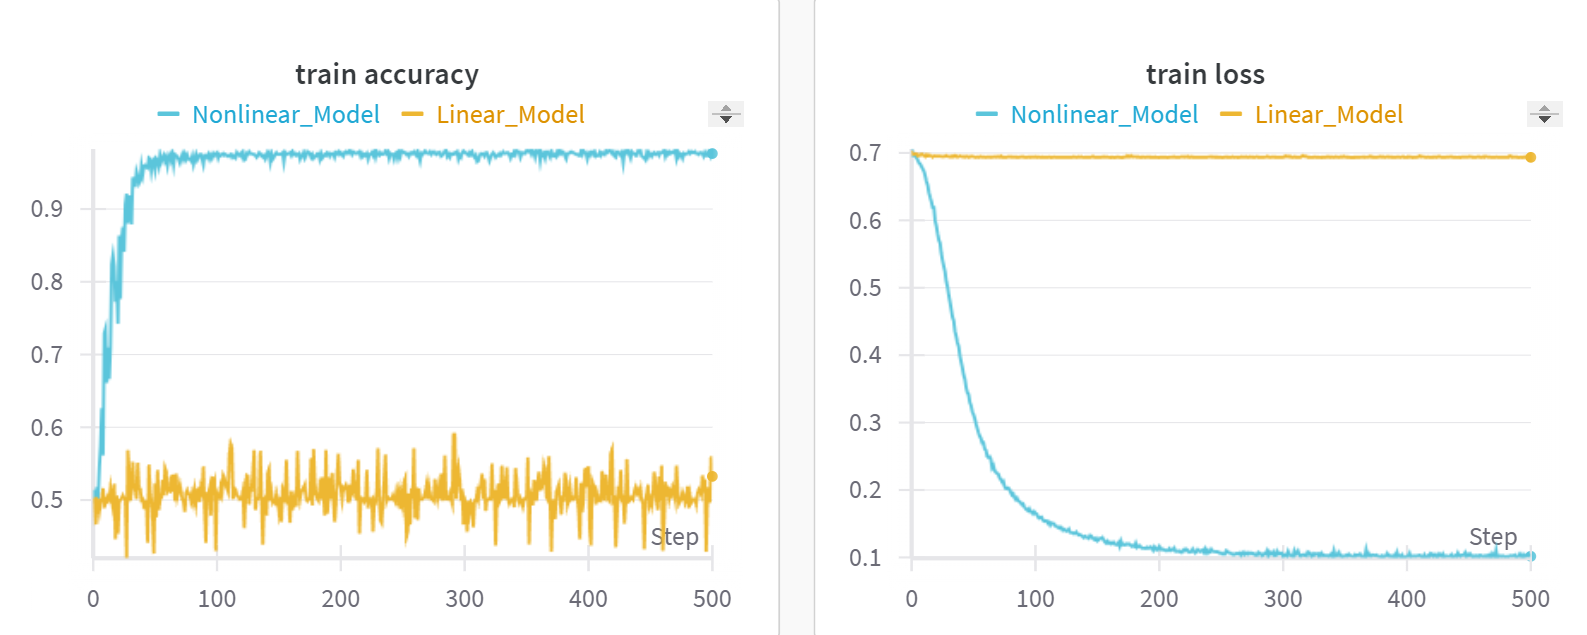\
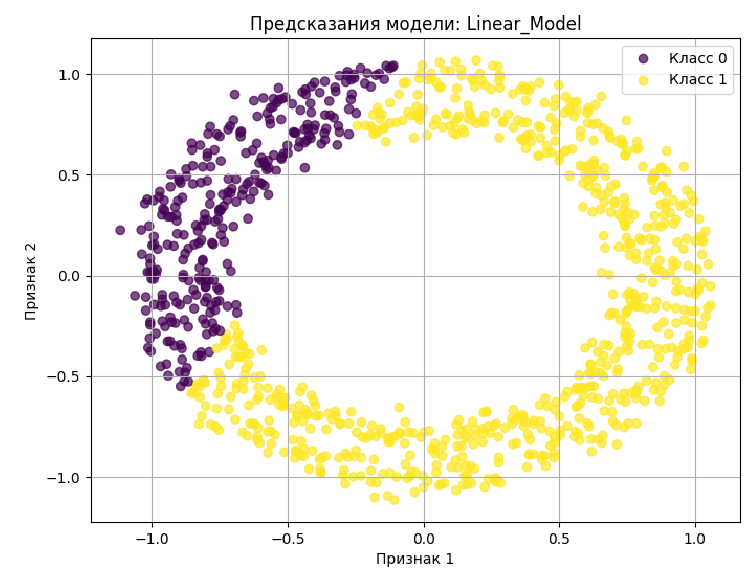 \
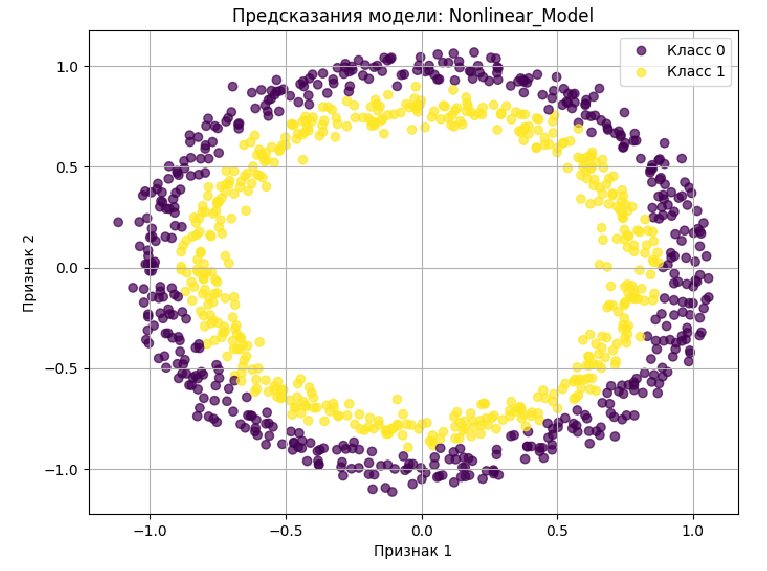

<p class="task" id="5"></p>

5\. Повторите задачу 2, реализовав логику ранней остановки. Для этого разделите данные на три части: обучающую, валидационную и тестовую. Остановите процесс обучения, если целевая метрика (F1) на валидации не увеличивалась в течении последних $k$ ($k$ - гиперпараметр метода) эпох. В момент остановки выведите сообщение с текущим номером эпохи. Сохраните номер эпохи, на которой процесс обучения был прерван, в виде summary данного запуска.

Помимо отслеживания метрик на обучающей и тестовой выборке, также отслеживайте метрики на валидационной выборке в процессе обучения.

Постройте таблицу `wandb.Table`, в которой содержится информация о:
* признаках объекта;
* правильном ответе;
* прогнозе модели;
* принадлежности к обучающему, валидационному или тестовому множеству.

Визуализируйте данную таблицу при помощи `wandb`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.

- [ ] Проверено на семинаре


In [22]:
X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

dataset = TensorDataset(X, y)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
def train_model_with_metrics(model, criterion, optimizer, train_loader, val_loader, n_epochs=1000, print_every=100, patience=10):
    epoch_losses = []
    train_accuracy_scores = []
    val_accuracy_scores = []
    val_f1_scores = []
    
    loss_metric = M.MeanMetric().to(device)
    train_accuracy_metric = M.Accuracy(task='binary').to(device)
    val_accuracy_metric = M.Accuracy(task='binary').to(device)
    val_f1_metric = M.F1Score('binary').to(device)
    
    best_val_f1 = 0.0
    epochs_no_improve = 0
    early_stop_epoch = None
    
    for epoch in range(n_epochs + 1):
        model.train()
        loss_metric.reset()
        train_accuracy_metric.reset()
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            loss_metric.update(loss)
            train_accuracy_metric.update(y_pred.argmax(dim=1), y_batch)
        
        epoch_loss = loss_metric.compute().item()
        epoch_losses.append(epoch_loss)
        train_accuracy = train_accuracy_metric.compute().item()
        train_accuracy_scores.append(train_accuracy)
        
        model.eval()
        val_accuracy_metric.reset()
        val_f1_metric.reset()
        
        with th.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred_val = model(X_val)
                val_accuracy_metric.update(y_pred_val.argmax(dim=1), y_val)
                val_f1_metric.update(y_pred_val.argmax(dim=1), y_val)
        
        val_accuracy = val_accuracy_metric.compute().item()
        val_f1 = val_f1_metric.compute().item()
        val_accuracy_scores.append(val_accuracy)
        val_f1_scores.append(val_f1)
        
        wandb.log({
            "epoch": epoch,
            "train loss": epoch_loss,
            "train accuracy": train_accuracy,
            "val accuracy": val_accuracy,
            "val F1 Score": val_f1
        })
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Ранняя остановка на эпохе {epoch}")
            wandb.summary["Early Stopped Epoch"] = epoch
            early_stop_epoch = epoch
            break
        
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
    
    return epoch_losses, train_accuracy_scores, val_accuracy_scores, val_f1_scores, early_stop_epoch

def model_eval(model, test_loader):
    model.eval()
    y_pred_list, y_test_list = [], []
    with th.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_list.append(y_pred)
            y_test_list.append(y_batch)
    
    y_pred_test = th.cat(y_pred_list).argmax(dim=1)
    y_test = th.cat(y_test_list)
    
    accuracy = M.Accuracy(task='binary').to(device)(y_pred_test, y_test).item()
    precision = M.Precision('binary').to(device)(y_pred_test, y_test).item()
    recall = M.Recall('binary').to(device)(y_pred_test, y_test).item()
    f1_score = M.F1Score('binary').to(device)(y_pred_test, y_test).item()
    
    wandb.summary["Test Accuracy"] = accuracy
    wandb.summary["Test Precision"] = precision
    wandb.summary["Test Recall"] = recall
    wandb.summary["Test F1Score"] = f1_score
    
    return y_test.cpu().numpy(), y_pred_test.cpu().numpy()

def log_predictions_table(train_dataset, val_dataset, test_dataset, model):
    all_features = th.cat([train_dataset.dataset[i][0].unsqueeze(0) for i in train_dataset.indices] +
                          [val_dataset.dataset[i][0].unsqueeze(0) for i in val_dataset.indices] +
                          [test_dataset.dataset[i][0].unsqueeze(0) for i in test_dataset.indices], dim=0).cpu().numpy()
    
    all_labels = th.cat([train_dataset.dataset[i][1].unsqueeze(0) for i in train_dataset.indices] +
                        [val_dataset.dataset[i][1].unsqueeze(0) for i in val_dataset.indices] +
                        [test_dataset.dataset[i][1].unsqueeze(0) for i in test_dataset.indices], dim=0).cpu().numpy()
    
    all_predictions = []
    model.eval()
    with th.no_grad():
        for X_batch, _ in DataLoader(train_dataset.dataset, batch_size=16, shuffle=False):
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch).argmax(dim=1)
            all_predictions.extend(y_pred_batch.cpu().numpy())
    
    split = ['train'] * len(train_dataset) + ['val'] * len(val_dataset) + ['test'] * len(test_dataset)
    
    df = pd.DataFrame(all_features, columns=[f"feature_{i}" for i in range(all_features.shape[1])])
    df['True Label'] = all_labels
    df['Predicted Label'] = all_predictions
    df['Split'] = split
    
    table = wandb.Table(dataframe=df)
    wandb.log({"Data Table": table})


In [24]:
models = {
    "Model_1": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Tanh(),
        nn.Linear(16, 2),
    ).to(device),
    
    "Model_2": nn.Sequential(
        nn.Linear(X.shape[1], 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
    ).to(device),

    "Model_3": nn.Sequential(
        nn.Linear(X.shape[1], 16),
        nn.Tanh(),
        nn.Linear(16, 16),
        nn.Tanh(),
        nn.Linear(16, 2),
    ).to(device),
}

In [26]:
for model_name, model in models.items():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.005)
    
    with wandb.init(
        project="03_1_monitoring",
        group="task_5",
        name=model_name,
        config={
            "learning_rate": 0.005,
            "batch_size": 16,
            "epochs": 10000,
            "patience": 100,
            "model": model_name
        }
    ):
        config = wandb.config
        epoch_losses, train_acc, val_acc, val_f1, stopped_epoch = train_model_with_metrics(
            model, 
            criterion, 
            optimizer, 
            train_loader,
            val_loader,
            n_epochs=config.epochs,
            print_every=100,
            patience=config.patience
        )
        
        y_test, y_pred = model_eval(model, test_loader)
        
        log_predictions_table(train_dataset, val_dataset, test_dataset, model)

Epoch [0/10000], Loss: 0.1046, Train Acc: 0.9729, Val Acc: 0.9800, Val F1: 0.9799
Epoch [100/10000], Loss: 0.1027, Train Acc: 0.9729, Val Acc: 0.9800, Val F1: 0.9799
Epoch [200/10000], Loss: 0.1022, Train Acc: 0.9757, Val Acc: 0.9800, Val F1: 0.9799
Ранняя остановка на эпохе 209


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train accuracy,▆▇▅▂▅▇▆▄▇▆▇▄█▅▅▇▂▅▄▅▇▇▁▄▄▅▇▅▅▇▅▅▇▆▅▆▇▇▅█
train loss,▄▇▅▂▄▂▃▄▃▄▂▄▃▃▃▃▃▁▂▃▁▂▁▂█▂▂▃▂▃▂▂▂▁▃▃▂▃▂▄
val F1 Score,▃▆▁▆▆▄▄▆▆▃▆▆▆██▆▆▆▆▆▆▆▄▆███▆▆█▆▄██▁▆▆█▆▆
val accuracy,▆▁▆▆▆▃▃▆▆▃▃▆▆▆▆▆▆▆▆▆██▆▆█▆▃▆▆▆▆▆▆▃▃█▆▆▆▆
Early Stopped Epoch,209
Test Accuracy,0.96667
Test F1Score,0.9697
Test Precision,0.95238
Test Recall,0.98765
epoch,209


Epoch [0/10000], Loss: 0.1473, Train Acc: 0.9329, Val Acc: 0.9733, Val F1: 0.9730
Epoch [100/10000], Loss: 0.1539, Train Acc: 0.9386, Val Acc: 0.9667, Val F1: 0.9664
Ранняя остановка на эпохе 104


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇█████
train accuracy,▄▃▄▃▇▇▃▆▄▂▄▄▃▅▃▄▄▄▅▆▁▄▅▇▅▅▂█▅▁▄▅▅▄▆▄▅▄▅▃
train loss,▃▂█▅▄▄▆▄▅▆▆▅▄▅▂█▁▄▃▆▄▅▃▂▄▄▁▅▇▄▂▄▁▅▄▅▄▃▆▄
val F1 Score,▆▆▆█▅▅▆▇▆▅▅▁▆▅▇▅▃▇▆▅▅▆▄█▅▅▆▅▇▇▃▃█▁▄▆▄▄▅▄
val accuracy,▆█▅▃▄▂▆▇▅▄▅▆▆▁▄▄▇▅▇▅▇▅▅▆▆▇▄▅█▂▃▄▆▄▆▄▇▄▅▄
Early Stopped Epoch,104
Test Accuracy,0.94
Test F1Score,0.9434
Test Precision,0.96154
Test Recall,0.92593
epoch,104


Epoch [0/10000], Loss: 0.1004, Train Acc: 0.9600, Val Acc: 0.9800, Val F1: 0.9799
Epoch [100/10000], Loss: 0.1053, Train Acc: 0.9629, Val Acc: 0.9800, Val F1: 0.9796
Ранняя остановка на эпохе 109


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train accuracy,▅▅▇▅▅▃▅▆▅▄▄▄▆▅▆▅▅▄▄▅▆▆▅▅▇▅▅█▂▂▅▄▅▆▂▅▁▄▅▆
train loss,▃▂▃▄▄▄▃▄▂▂▅▃▁▃▄▄▄▃▃▃▄▄▂▄▂▅▅█▂▂▄▂▁▄▃▂▄▁▄▂
val F1 Score,▆▆▄▅█▇▇▅▇▃▆▆▇▇▆█▆▁▇▆▅▆▅▆▄▇▅▅▂▆▆▄▇▂▆▅▃▆▅▆
val accuracy,▆▆▄▆▆▃▆▅▄▆▂▆▅▄▅█▅▆▆▃▆▆▄▆▆▆▄▇▇▄▁▃▆▅▄▂▅▄▃▅
Early Stopped Epoch,109
Test Accuracy,0.94667
Test F1Score,0.94937
Test Precision,0.97403
Test Recall,0.92593
epoch,109


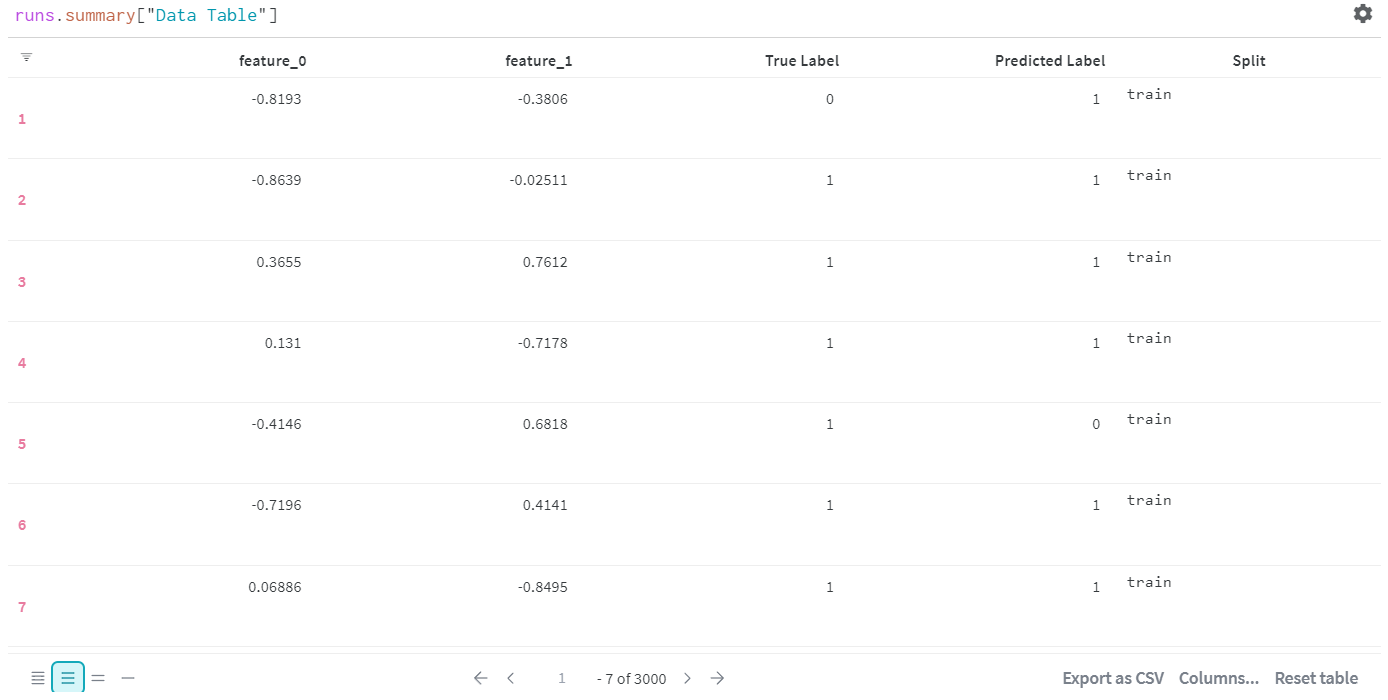

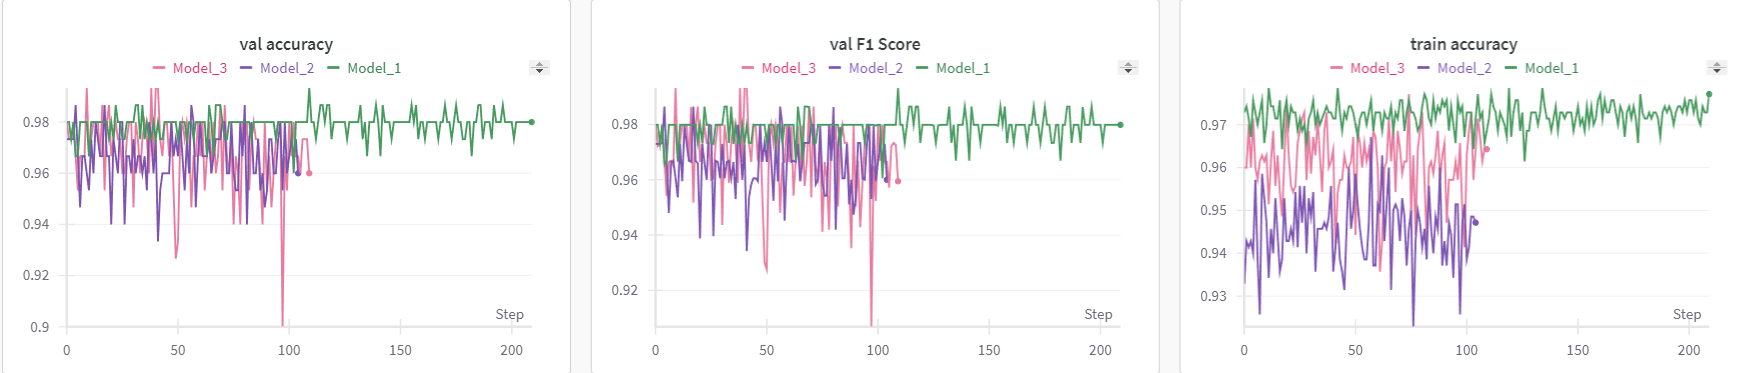 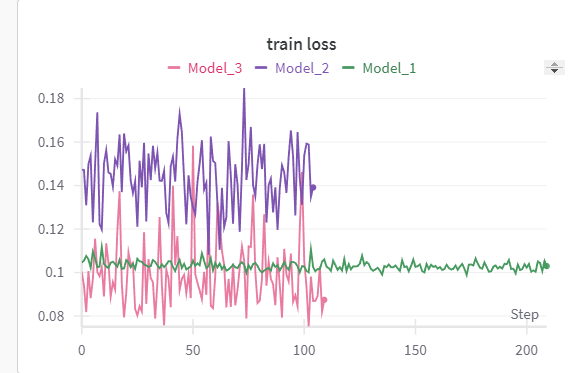